In [2]:
import zipfile
import os

zip_path = 'JPEGImages.zip'
output_dir = 'JPEGImages'

# Crear carpeta de destino si no existe
os.makedirs(output_dir, exist_ok=True)

# Descomprimir
with zipfile.ZipFile(zip_path, 'r') as zf:
    zf.extractall(output_dir)

print(f"✅ Descomprimido {zip_path} → {output_dir}/")
print("Primeras imágenes extraídas:")
print(os.listdir(output_dir)[:10])


✅ Descomprimido JPEGImages.zip → JPEGImages/
Primeras imágenes extraídas:
['JPEGImages']


In [3]:
import os
from pathlib import Path

# 1) Directorio base = carpeta actual del notebook
BASE_DIR   = Path.cwd()
IMAGES_DIR = BASE_DIR / "JPEGImages"/"JPEGImages"
TRAIN_TXT  = BASE_DIR / "train_voc.txt"
VAL_TXT    = BASE_DIR / "val_voc.txt"

# 2) Verificación de existencia
print(f"BASE_DIR   = {BASE_DIR}")
print(f"IMAGES_DIR exists? {IMAGES_DIR.exists()} → {IMAGES_DIR}")
print(f"TRAIN_TXT  exists? {TRAIN_TXT.exists()} → {TRAIN_TXT}")
print(f"VAL_TXT    exists? {VAL_TXT.exists()} → {VAL_TXT}")

# 3) Listar contenidos para confirmar
print("\nContenido de la carpeta actual:")
!ls -1


BASE_DIR   = c:\Users\Santiago\OneDrive - miuandes.cl\Escritorio\newland\clases\VocPascal
IMAGES_DIR exists? True → c:\Users\Santiago\OneDrive - miuandes.cl\Escritorio\newland\clases\VocPascal\JPEGImages\JPEGImages
TRAIN_TXT  exists? True → c:\Users\Santiago\OneDrive - miuandes.cl\Escritorio\newland\clases\VocPascal\train_voc.txt
VAL_TXT    exists? True → c:\Users\Santiago\OneDrive - miuandes.cl\Escritorio\newland\clases\VocPascal\val_voc.txt

Contenido de la carpeta actual:


"ls" no se reconoce como un comando interno o externo,
programa o archivo por lotes ejecutable.


In [4]:
files = os.listdir(IMAGES_DIR)
print(f"Total de archivos en JPEGImages/: {len(files)}")
print("Primeros 10 archivos:", files[:10])

Total de archivos en JPEGImages/: 17125
Primeros 10 archivos: ['2007_000027.jpg', '2007_000032.jpg', '2007_000033.jpg', '2007_000039.jpg', '2007_000042.jpg', '2007_000061.jpg', '2007_000063.jpg', '2007_000068.jpg', '2007_000121.jpg', '2007_000123.jpg']


In [6]:
from PIL import Image
import os
from pathlib import Path

# 1) Clases VOC-Pascal y mapeo a índices
VOC_CLASSES = [
    'aeroplane','bicycle','bird','boat','bottle','bus','car','cat','chair',
    'cow','diningtable','dog','horse','motorbike','person','pottedplant',
    'sheep','sofa','train','tvmonitor'
]
class_to_idx = {c:i for i,c in enumerate(VOC_CLASSES)}

# 2) Función para cargar y recortar
def cargar_datos(archivo_txt, carpeta_imagenes, min_area=100):
    imagenes = []
    etiquetas = []

    with open(archivo_txt, 'r') as f:
        for line in f:
            parts = line.strip().split()

            # Validar que la línea tiene 6 elementos
            if len(parts) != 6:
                continue

            try:
                fn, clase, x1, y1, x2, y2 = parts
                if not fn.lower().endswith('.jpg'):
                    fn += '.jpg'
                img_path = carpeta_imagenes / fn
                if not img_path.exists():
                    continue
                x1, y1, x2, y2 = map(int, [x1, y1, x2, y2])
                area = (x2 - x1) * (y2 - y1)
                if area < min_area:
                    continue
                imagenes.append((img_path, (x1, y1, x2, y2)))
                etiquetas.append(clase)
            except Exception as e:
                print(f"⚠️ Error en línea: {line.strip()} — {e}")
                continue

    return imagenes, etiquetas


# 3) Rutas locales
BASE_DIR   = Path.cwd()
IMAGES_DIR = BASE_DIR / "JPEGImages"/"JPEGImages"
TRAIN_TXT  = BASE_DIR / "train_voc.txt"
VAL_TXT    = BASE_DIR / "val_voc.txt"

# 4) Ejecutar carga
imgs_train, y_train = cargar_datos(TRAIN_TXT, IMAGES_DIR)
imgs_val,   y_val   = cargar_datos(VAL_TXT,   IMAGES_DIR)

print(f"✔️ Entrenamiento: {len(imgs_train)} imágenes — Validación: {len(imgs_val)} imágenes")


✔️ Entrenamiento: 3621 imágenes — Validación: 3717 imágenes


In [8]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from PIL import Image
import clip  # pip install git+https://github.com/openai/CLIP.git
import numpy as np
from tqdm import tqdm

# Dispositivo
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# 1) Preprocesamiento común
preprocess = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225]),
])

class PilDataset(Dataset):
    def __init__(self, imgs, tfm):
        self.imgs = imgs  # lista de tuplas: (ruta, bbox)
        self.tfm  = tfm

    def __len__(self):
        return len(self.imgs)

    def __getitem__(self, idx):
        path, _ = self.imgs[idx]  # ignoramos el bounding box
        img = Image.open(path).convert("RGB")
        return self.tfm(img)


def extract(encoder, loader, name):
    encoder.eval()
    feats = []
    with torch.no_grad():
        for batch in tqdm(loader, desc=f"Extract {name}"):
            batch = batch.to(device, non_blocking=True)
            out   = encoder(batch)
            feats.append(out.cpu().numpy())
    return np.vstack(feats)

# 2) Cargar encoders

# 2.1 ResNet34 → 512-d
resnet = models.resnet34(weights=models.ResNet34_Weights.DEFAULT).to(device)
resnet.fc = torch.nn.Identity()

# 2.2 DINOv2 → 384-d
dino = torch.hub.load(
    'facebookresearch/dinov2:main',
    'dinov2_vits14',
    pretrained=True
).to(device)

# 2.3 CLIP visual → 512-d
clip_model, _ = clip.load("ViT-B/32", device=device)
clip_enc = clip_model.visual.float().to(device)  # convert weights to float32

# 3) DataLoaders
batch_size = 32
train_loader = DataLoader(
    PilDataset(imgs_train, preprocess),
    batch_size=batch_size,
    shuffle=False,
    num_workers=0,
    pin_memory=torch.cuda.is_available()
)
val_loader = DataLoader(
    PilDataset(imgs_val, preprocess),
    batch_size=batch_size,
    shuffle=False,
    num_workers=0,
    pin_memory=torch.cuda.is_available()
)

# 4) Extraer features
Xr_train = extract(resnet,   train_loader, "ResNet34-train")
Xr_val   = extract(resnet,   val_loader,   "ResNet34-val")

Xd_train = extract(dino,     train_loader, "DINOv2-train")
Xd_val   = extract(dino,     val_loader,   "DINOv2-val")

Xc_train = extract(clip_enc, train_loader, "CLIP-train")
Xc_val   = extract(clip_enc, val_loader,   "CLIP-val")

print("Shapes:", Xr_train.shape, Xd_train.shape, Xc_train.shape)
# Ej: (N_train,512), (N_train,384), (N_train,512)

# 5) (Opcional) Concatenar todo
X_train_all = np.concatenate([Xr_train, Xd_train, Xc_train], axis=1)
X_val_all   = np.concatenate([Xr_val,   Xd_val,   Xc_val],   axis=1)
print("Espacio combinado:", X_train_all.shape, X_val_all.shape)


Using device: cuda


Using cache found in C:\Users\Santiago/.cache\torch\hub\facebookresearch_dinov2_main
Extract CLIP-val: 100%|██████████| 117/117 [00:16<00:00,  6.99it/s]


Shapes: (3621, 512) (3621, 384) (3621, 512)
Espacio combinado: (3621, 1408) (3717, 1408)



=== Encoder: ResNet34 ===
MLP acc: 0.7046004842615012
SVM acc: 0.7290825934893731
RF acc: 0.6876513317191283


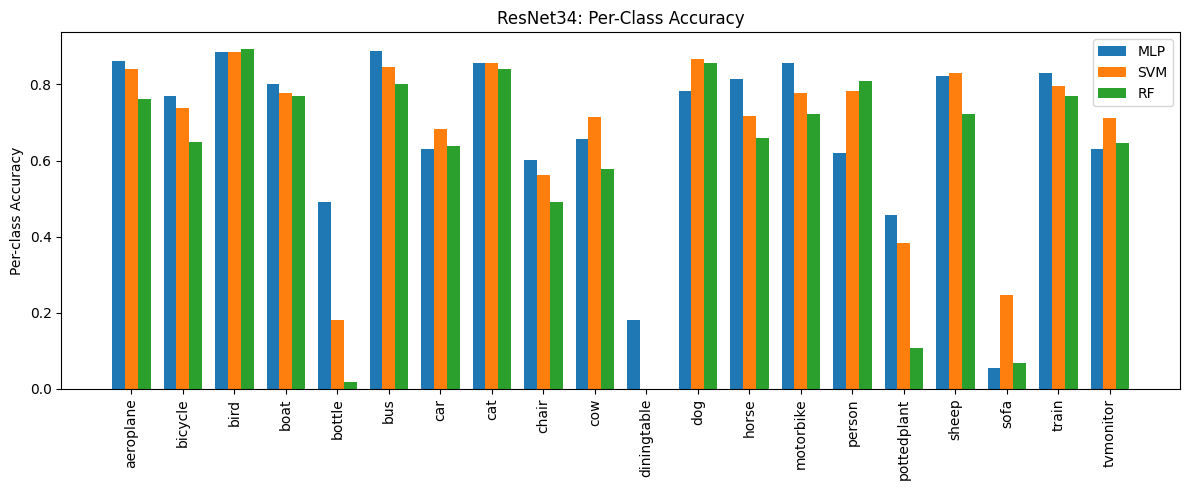

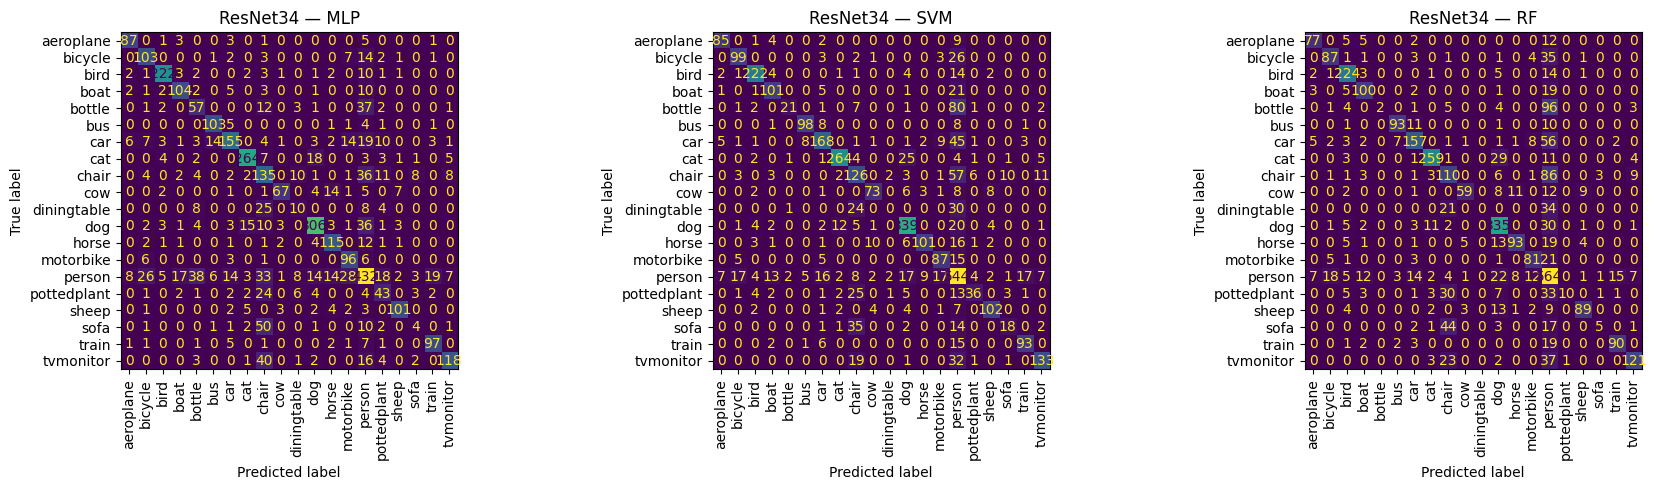


=== Encoder: DINOv2 ===
MLP acc: 0.7718590260963142
SVM acc: 0.7987624428302394
RF acc: 0.7263922518159807


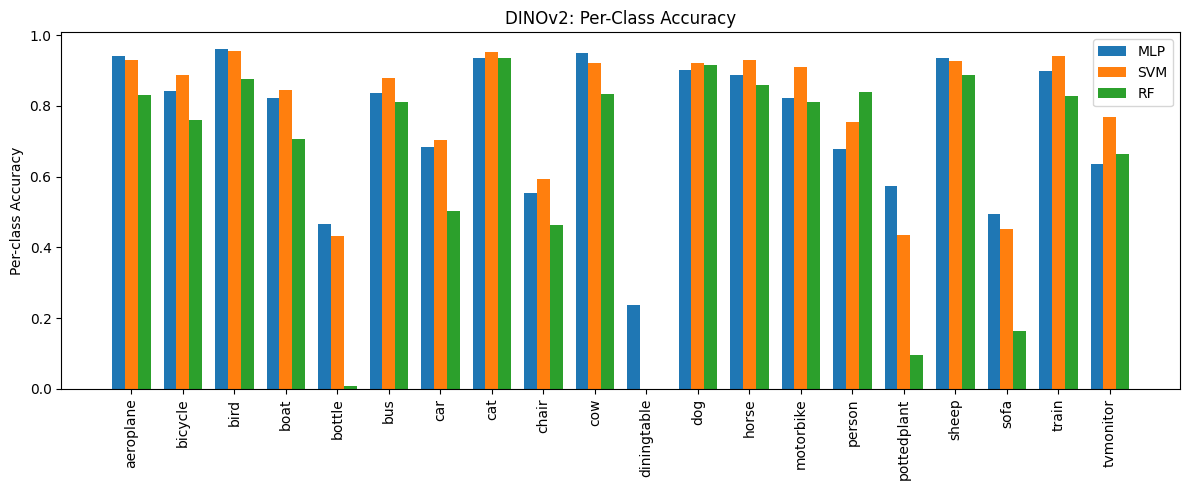

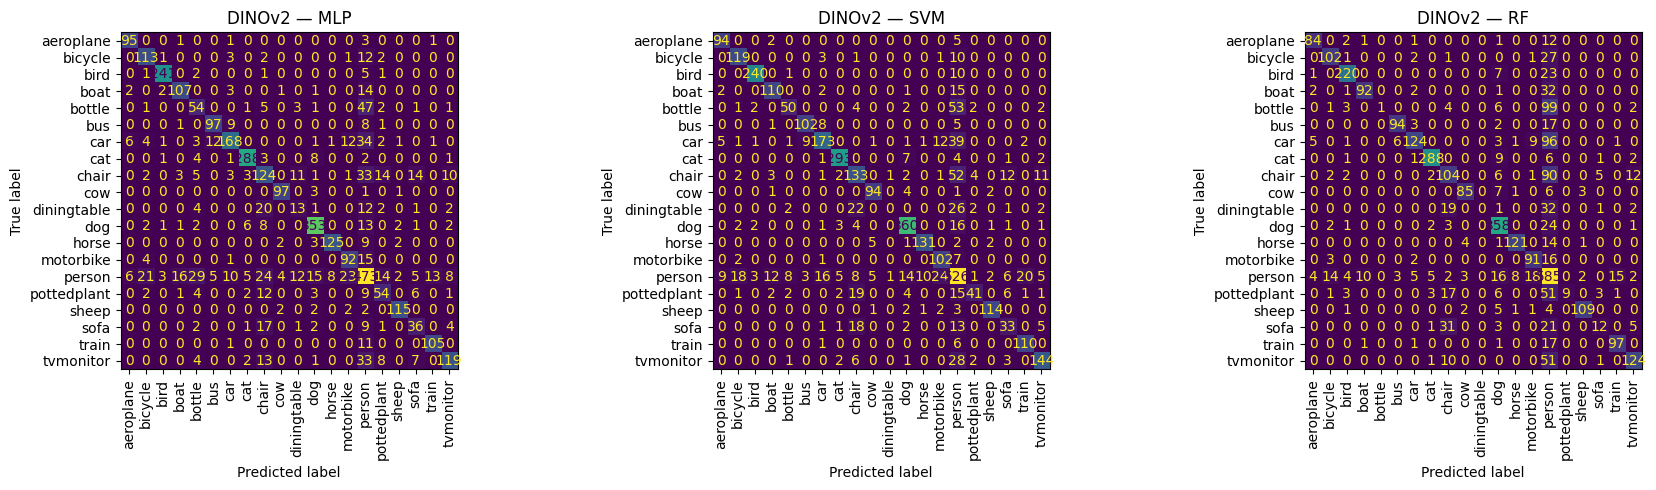


=== Encoder: CLIP ===
MLP acc: 0.7608286252354048
SVM acc: 0.7785848802797956
RF acc: 0.7237019101425881


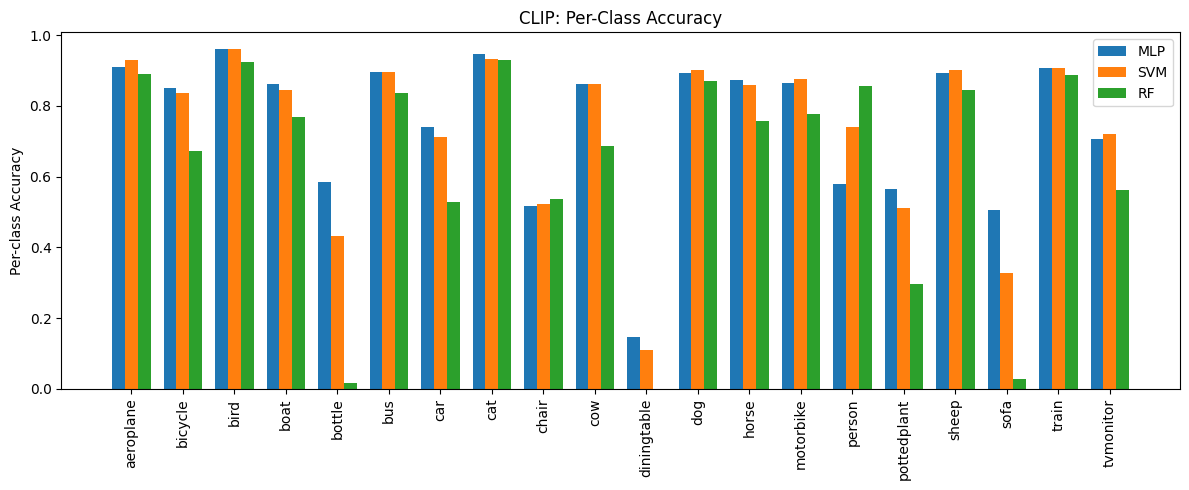

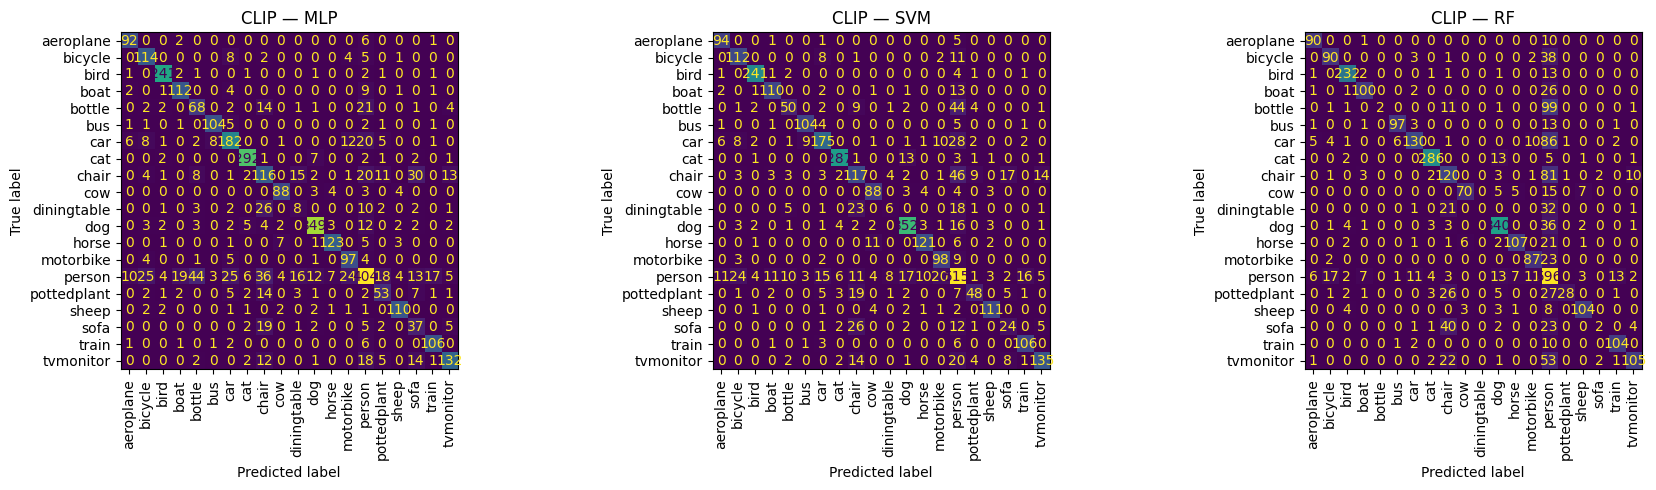

In [15]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from torch import nn, optim
from torch.utils.data import TensorDataset, DataLoader

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Mapear etiquetas string a enteros
y_tr = np.array([class_to_idx[label] for label in y_train])
y_va = np.array([class_to_idx[label] for label in y_val])
idx_to_class = {v: k for k, v in class_to_idx.items()}

# Encoders ya definidos
encoders = {
    'ResNet34': (Xr_train, Xr_val),
    'DINOv2':   (Xd_train, Xd_val),
    'CLIP':     (Xc_train, Xc_val),
}

# MLP con capa oculta
class MLPCustom(nn.Module):
    def __init__(self, in_dim, hid_dim, out_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_dim, hid_dim),
            nn.ReLU(),
            nn.Linear(hid_dim, out_dim)
        )
    def forward(self, x): return self.net(x)

def train_mlp_model(X_tr, y_tr, X_va, y_va, hid_dim=256, epochs=10, bs=64):
    X_tr_t = torch.tensor(X_tr, dtype=torch.float32).to(device)
    y_tr_t = torch.tensor(y_tr, dtype=torch.long).to(device)
    X_va_t = torch.tensor(X_va, dtype=torch.float32).to(device)
    y_va_t = torch.tensor(y_va, dtype=torch.long).to(device)
    train_ds = TensorDataset(X_tr_t, y_tr_t)
    train_ld = DataLoader(train_ds, batch_size=bs, shuffle=True)

    mlp = MLPCustom(X_tr.shape[1], hid_dim, len(class_to_idx)).to(device)
    opt = optim.Adam(mlp.parameters(), lr=1e-3)
    crit = nn.CrossEntropyLoss()

    for _ in range(epochs):
        mlp.train()
        for xb, yb in train_ld:
            opt.zero_grad()
            loss = crit(mlp(xb), yb)
            loss.backward()
            opt.step()

    mlp.eval()
    with torch.no_grad():
        preds = mlp(X_va_t).argmax(dim=1).cpu().numpy()
    acc = accuracy_score(y_va, preds)
    return acc, mlp

# SVM
def train_svm(X_tr, y_tr, X_va, y_va):
    grid = GridSearchCV(SVC(kernel='rbf'), 
                        {'C':[0.01,0.1,1,10],'gamma':['scale','auto',0.01,0.1]},
                        cv=3, n_jobs=-1)
    grid.fit(X_tr, y_tr)
    acc = accuracy_score(y_va, grid.best_estimator_.predict(X_va))
    return acc, grid.best_estimator_

# Random Forest
def train_rf(X_tr, y_tr, X_va, y_va):
    rf = RandomForestClassifier(n_estimators=200, random_state=42)
    rf.fit(X_tr, y_tr)
    acc = rf.score(X_va, y_va)
    return acc, rf

# Per-class accuracy
def per_class_acc(y_true, y_pred):
    n = len(class_to_idx)
    acc = []
    for i in range(n):
        mask = (y_true == i)
        acc.append((y_pred[mask] == i).sum() / mask.sum() if mask.sum() else 0)
    return np.array(acc)

# Loop principal
for enc_name, (X_tr, X_va) in encoders.items():
    print(f"\n=== Encoder: {enc_name} ===")

    # MLP
    acc_mlp, mlp = train_mlp_model(X_tr, y_tr, X_va, y_va)
    print("MLP acc:", acc_mlp)

    # SVM
    acc_svm, best_svm = train_svm(X_tr, y_tr, X_va, y_va)
    print("SVM acc:", acc_svm)

    # Random Forest
    acc_rf, best_rf = train_rf(X_tr, y_tr, X_va, y_va)
    print("RF acc:", acc_rf)

    # Predicciones
    y_preds = {}
    X_va_t = torch.tensor(X_va, dtype=torch.float32).to(device)
    with torch.no_grad():
        y_preds['MLP'] = mlp(X_va_t).argmax(dim=1).cpu().numpy()
    y_preds['SVM'] = best_svm.predict(X_va)
    y_preds['RF']  = best_rf.predict(X_va)

    # Gráfico de per-class accuracy
    pcs = {name: per_class_acc(y_va, y_p) for name, y_p in y_preds.items()}
    x = np.arange(len(class_to_idx))
    width = 0.25
    plt.figure(figsize=(12,5))
    for i, (name, values) in enumerate(pcs.items()):
        plt.bar(x + (i - 1)*width, values, width, label=name)
    plt.xticks(x, list(class_to_idx.keys()), rotation=90)
    plt.ylabel("Per-class Accuracy")
    plt.title(f"{enc_name}: Per-Class Accuracy")
    plt.legend()
    plt.tight_layout()
    plt.show()

    # Matrices de confusión
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    for ax, (clf_name, y_pred) in zip(axes, y_preds.items()):
        cm = confusion_matrix(y_va, y_pred)
        disp = ConfusionMatrixDisplay(cm, display_labels=list(class_to_idx.keys()))
        disp.plot(ax=ax, xticks_rotation=90, colorbar=False)
        ax.set_title(f"{enc_name} — {clf_name}")
    plt.tight_layout()
    plt.show()
